In [ ]:
import torch
import gym
from torch import nn
import numpy as np
import torch.functional as F
from collections import namedtuple
import random
import math

**making model**

In [ ]:
class Network(nn.Module):
  def __init__(self,N):
    super(Network, self).__init__()
    self.layers=nn.ModuleList([
    nn.Linear(4,32),
    nn.Linear(32,64),
    nn.Linear(64,128),
    nn.Linear(128,64),
    nn.Linear(64,2*N)])
    
    self.N=N
  def forward(self,state):
    x=state
    for i in range(4):
      x=self.layers[i](x)
      x=nn.ReLU()(x)
    x=self.layers[4](x)
    return nn.Softmax(dim=2)(x.view(-1, 2,self.N)),nn.LogSoftmax(dim=2)(x.view(-1, 2,self.N))
  

**Replay buffer**

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))
class ReplayMemory:

    def __init__(self, capacity,batch_size):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.batch_size=batch_size

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

**Agent**

Note:In the paper of C51 algorithm,they've chosen Vmin=-10 and Vmax=10.But I examined some values and specualted that -100 and 100 works well for CartPole.

In [ ]:
class Agent:
  def __init__(self,N):
    self.q=Network(N)
    self.target=Network(N)
    self.checkpoint=Network(N)
    self.update_target()
    self.Vmin=-100
    self.Vmax=100
    self.gamma=0.99
    self.delta_z=(self.Vmax-self.Vmin)/(N-1)
    self.optimizer =torch.optim.Adam(self.q.parameters(),lr=0.001)

    self.eps=0.2
    self.N=N
    self.t=0

  def action(self,state):
    if np.random.randn()<self.eps:
      return np.random.randint(0,2)
    else:
      # self.q.eval()
        z_dist = torch.from_numpy(
        np.array([[self.Vmin + i * self.delta_z for i in range(self.N)]]))
        z_dist = torch.unsqueeze(z_dist, 2).float()
        Q_dist, _  = self.q(state)#
        Q_dist = Q_dist.detach()
        Q_target = torch.matmul(Q_dist, z_dist)

        return Q_target.argmax(dim=1)[0].detach().cpu().numpy()[0]
  def greedy_action(self,state):
      q,_=self.q(state)
      q=q.detach().cpu().numpy()
      z=np.arange(self.Vmin,self.Vmax+self.delta_z,self.delta_z)
      d=np.sum(z*q,axis=2)
      return d.argmax(axis=1)[0]
  def update_target(self):
    self.target.load_state_dict(self.q.state_dict())

  #for saving the best weight
  def save(self):
    self.checkpoint.load_state_dict(self.q.state_dict())

  #loading the best weight
  def load(self):
    self.q.load_state_dict(self.checkpoint.state_dict())
  
  #update Q network
  def update(self,buffer):
    if len(buffer)<buffer.batch_size:
      return 
    batch=buffer.sample()#taking some sanples
    batch = Transition(*zip(*batch))
    batch_size=buffer.batch_size
    states=batch.state
    next_states=batch.next_state
    rewards=torch.FloatTensor(batch.reward)
    dones=torch.FloatTensor(batch.done)
    actions=batch.action
    actions = torch.tensor(actions).long()
    z_dist = torch.from_numpy(np.array([[self.Vmin + i*self.delta_z for i in range(self.N)]]*batch_size))#making z vector
    z_dist = torch.unsqueeze(z_dist, 2).float()

    _, log_q = self.q(torch.FloatTensor(states))#calculating log pi(Xt,a)
    log_q = log_q[torch.arange(batch_size), actions, :]
    q_next, _ = self.target(torch.FloatTensor(next_states))#calculating pi(Xt+1,a) using Q network
    q_next = q_next.detach()
    Q_target = torch.matmul(q_next, z_dist).squeeze(1)
    
    q_next_t, _ = self.q(torch.FloatTensor(next_states))#calculating pi(Xt+1,a) using target network

    q_target2 = torch.matmul(q_next_t, z_dist).squeeze(1)
    q_next_optimal= q_next[torch.arange(batch_size), torch.argmax(q_target2, dim=1).squeeze(1),:]

    m = torch.zeros(batch_size,self.N)
    for j in range(self.N):
      T_zj = torch.clamp(rewards + self.gamma * (1-dones) * (self.Vmin + j*self.delta_z), min = self.Vmin, max = self.Vmax)
      bj = (T_zj - self.Vmin)/self.delta_z
      l = bj.floor().long()
      u = bj.ceil().long()
      Q_l = torch.zeros(m.size())
      Q_l.scatter_(1, l.reshape((batch_size,1)), q_next_optimal[:,j].unsqueeze(1)*(u.float() -bj.float()).unsqueeze(1))
      Q_u = torch.zeros(m.size())
      Q_u.scatter_(1, u.reshape((batch_size,1)), q_next_optimal[:,j].unsqueeze(1)*(-l.float()+bj.float()).unsqueeze(1))
      m += Q_l
      m += Q_u
    
    self.optimizer.zero_grad()
    loss = - torch.sum(torch.sum(torch.mul(log_q, m),-1),-1) / batch_size
    
    loss.backward()
    self.optimizer.step()
    self.t+=1
  
    #updating target network
    if self.t==10:
  
      self.update_target()
      self.t=0
  
  

  

In [ ]:
agent21=Agent(21)
agent51=Agent(51)
agent80=Agent(80)
agent101=Agent(101)
agent120=Agent(120)
agent150=Agent(150)
agent200=Agent(200)

In [ ]:
import matplotlib.pyplot as plt

def reward_return(agent):
  EPOCH=1000
  BATCH_SIZE=128
  maxi=0
  env=gym.make("CartPole-v1")
  rewards=[]
  buffer=ReplayMemory(10000,BATCH_SIZE)
  for i in range(1):
    print(i)
    curr_rewards = []
    for epoch in range(EPOCH):
      state=env.reset()
      t=0
      while True:
        action=agent.action(torch.FloatTensor([state]))
        next_state,reward,done,_=env.step(action)
        buffer.push(state, action, next_state, reward,done)
        agent.update(buffer)
        state=next_state
        t+=reward
        if done:
          break
      if epoch%100 == 0:
        print("episode:",epoch, "   reward:",t)

      curr_rewards.append(t)
      if t>maxi:
        agent.save()
        maxi=t
    rewards.append(curr_rewards)
  mean_rewards = []
  arrays = [np.array(x) for x in rewards]
  mean_rewards = [np.mean(k) for k in zip(*arrays)]

  #plt.figure(figsize=(20,15))
  #plt.plot(np.arange(len(rewards)),rewards)
  #plt.xlabel("Episodes")
  #plt.ylabel("Rewards (Max=200)")
  #plt.show()
  return curr_rewards
    


In [ ]:
def plot_graph(rewards, max, n):
  plt.plot(np.arange(len(rewards)), rewards)
  plt.xlabel("Episodes")
  plt.ylabel("Returns")
  title = str(n) + " Bins and Batch size = 128"
  plt.title(title)
  plt.show()

In [ ]:
rewards_21 = reward_return(agent21)

0
episode: 0    reward: 35.0
episode: 100    reward: 19.0
episode: 200    reward: 13.0
episode: 300    reward: 14.0
episode: 400    reward: 33.0
episode: 500    reward: 16.0
episode: 600    reward: 55.0
episode: 700    reward: 19.0
episode: 800    reward: 41.0
episode: 900    reward: 12.0


In [ ]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

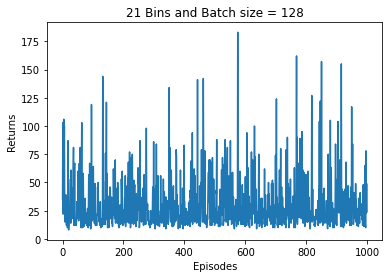

In [ ]:
plot_graph(rewards_21, max(rewards_21),21)

In [ ]:
rewards_51 = reward_return(agent51)

0
episode: 0    reward: 40.0
episode: 100    reward: 37.0
episode: 200    reward: 22.0
episode: 300    reward: 13.0
episode: 400    reward: 29.0
episode: 500    reward: 24.0
episode: 600    reward: 58.0
episode: 700    reward: 13.0
episode: 800    reward: 19.0
episode: 900    reward: 30.0


In [ ]:
max(rewards_51)

252.0

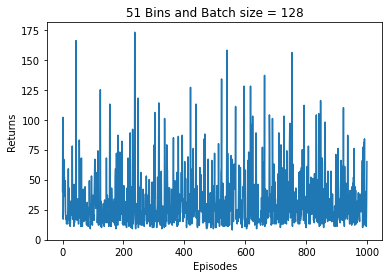

In [ ]:
plot_graph(rewards_51, max(rewards_51), 51)

In [ ]:
rewards_80 = reward_return(agent80)

0
episode: 0    reward: 13.0
episode: 100    reward: 28.0
episode: 200    reward: 75.0
episode: 300    reward: 31.0
episode: 400    reward: 12.0
episode: 500    reward: 13.0
episode: 600    reward: 25.0
episode: 700    reward: 58.0
episode: 800    reward: 24.0
episode: 900    reward: 27.0


In [ ]:
max(rewards_80)

286.0

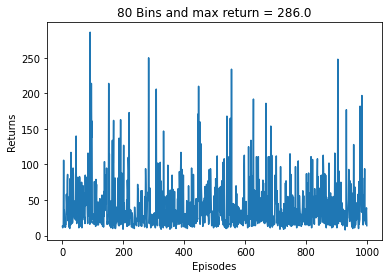

In [ ]:
plot_graph(rewards_80, max(rewards_80), 80)

In [ ]:
rewards_101 = reward_return(agent101)

0
episode: 0    reward: 50.0
episode: 100    reward: 15.0
episode: 200    reward: 34.0
episode: 300    reward: 36.0
episode: 400    reward: 38.0
episode: 500    reward: 32.0
episode: 600    reward: 30.0
episode: 700    reward: 13.0
episode: 800    reward: 34.0
episode: 900    reward: 13.0


In [ ]:
max(rewards_101)

248.0

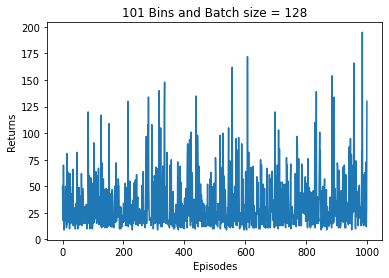

In [ ]:
plot_graph(rewards_101, max(rewards_101), 101)

In [ ]:
rewards_120 = reward_return(agent120)

0
episode: 0    reward: 12.0
episode: 100    reward: 20.0
episode: 200    reward: 138.0
episode: 300    reward: 41.0
episode: 400    reward: 91.0
episode: 500    reward: 29.0
episode: 600    reward: 17.0
episode: 700    reward: 23.0
episode: 800    reward: 20.0
episode: 900    reward: 55.0


In [ ]:
max(rewards_120)

172.0

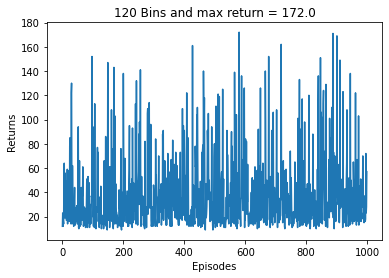

In [ ]:
plot_graph(rewards_120, max(rewards_120), 120)

In [ ]:
rewards_150 = reward_return(agent150)

0
episode: 0    reward: 19.0
episode: 100    reward: 28.0
episode: 200    reward: 18.0
episode: 300    reward: 43.0
episode: 400    reward: 19.0
episode: 500    reward: 86.0
episode: 600    reward: 18.0
episode: 700    reward: 13.0
episode: 800    reward: 23.0
episode: 900    reward: 49.0


In [ ]:
max(rewards_150)

272.0

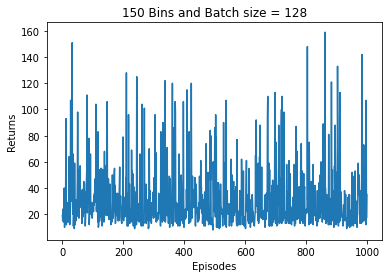

In [ ]:
plot_graph(rewards_150, max(rewards_150), 150)

In [ ]:
rewards_200 = reward_return(agent200)

0
episode: 0    reward: 53.0
episode: 100    reward: 14.0
episode: 200    reward: 17.0
episode: 300    reward: 31.0
episode: 400    reward: 50.0
episode: 500    reward: 36.0
episode: 600    reward: 105.0
episode: 700    reward: 61.0
episode: 800    reward: 13.0
episode: 900    reward: 50.0


In [ ]:
max(rewards_200)

351.0

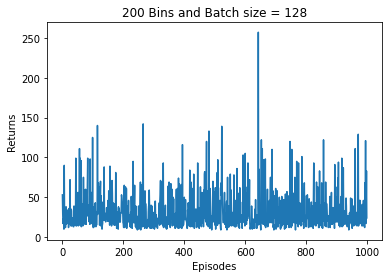

In [ ]:
plot_graph(rewards_200, max(rewards_200), 200)

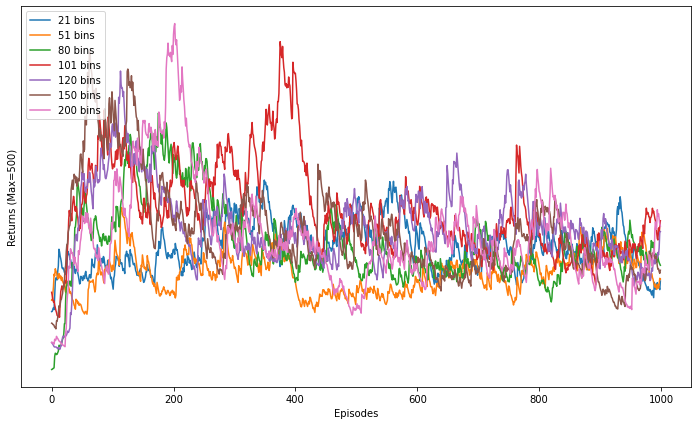

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(len(rewards_21)),smooth(rewards_21, 0.95), label="21 bins")
plt.plot(np.arange(len(rewards_51)),smooth(rewards_51, 0.95), label="51 bins")
plt.plot(np.arange(len(rewards_80)),smooth(rewards_80, 0.95), label="80 bins")
plt.plot(np.arange(len(rewards_101)),smooth(rewards_101, 0.95), label="101 bins")
plt.plot(np.arange(len(rewards_120)),smooth(rewards_120, 0.95), label="120 bins")
plt.plot(np.arange(len(rewards_150)),smooth(rewards_150, 0.95), label="150 bins")
plt.plot(np.arange(len(rewards_200)),smooth(rewards_200, 0.95), label="200 bins")
plt.xlabel("Episodes")
plt.ylabel("Returns (Max=500)")
plt.legend(loc="upper left", )
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.show()


In [ ]:
def training_agent_time(agent):
  BATCH_SIZE=64
  maxi=0
  env=gym.make("CartPole-v1")
  rewards=[]
  reward = 0
  buffer=ReplayMemory(10000,BATCH_SIZE)
  start_time = time.time()
  while reward < 475:
    state=env.reset()
    t=0
    while True:
      action=agent.action(torch.FloatTensor([state]))
      next_state,reward,done,_=env.step(action)
      buffer.push(state, action, next_state, reward,done)
      agent.update(buffer)
      state=next_state
      t+=reward
      if done:
        break
      
    #print("episode:",epoch, "   reward:",t)
    
    rewards.append(t)
    if t>maxi:
      agent.save()
      maxi=t
  
  training_time = time.time() - start_time
  print("Training time = ", training_time)
  plt.figure(figsize=(20,15))
  plt.plot(np.arange(len(rewards)),rewards)
  plt.xlabel("Episodes")
  plt.ylabel("Rewards (Max=200)")
  plt.show()
    

In [ ]:
'''
agent21=Agent(21)
agent51=Agent(51)
agent80=Agent(80)
agent101=Agent(101)
agent120=Agent(120)
agent150=Agent(150)
agent200=Agent(200)
'''

In [ ]:
training_agent_time(agent51)

**Test**

In [ ]:
agent.load()
t=0
for i in range(100):
  state=env.reset()


  while True:
    ac=agent.greedy_action(torch.FloatTensor([state]))
    state,reward,done,_=env.step(ac)
    t+=reward
    if done:
      break
print("Average reward:",t/100)
  
  


Hence,the agent did 100 tests and could achieve average reward of 195.19!

**Run on a signle episode**

In [ ]:
#hard copy from: https://github.com/berkeleydeeprlcourse/homework_fall2020/blob/master/hw1/cs285/infrastructure/colab_utils.py (Deep RL course)
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


def show_video():
  mp4list = glob.glob('/content/video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, '/content/video', force=True)
  return env


In [ ]:
!pip install gym pybullet
!sudo apt-get install xvfb
!pip install pyvirtualdisplay

In [ ]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
display.start()

In [ ]:
agent.load()
t=0
env=wrap_env(gym.make("CartPole-v1"))
state=env.reset()
while True:
  ac=agent.greedy_action(torch.FloatTensor([state]))
  state,reward,done,_=env.step(ac)
  env.render(mode='rgb_array')
  t+=reward
  if done:
    break
print("Reward:",t)
env.close()
show_video()
  
  
